In [1]:
!pip install roboflow
!pip install pycocotools

from roboflow import Roboflow
rf = Roboflow(api_key="ihYIM7BFL7rugXS2qI8E")
project = rf.workspace("balasai").project("ships-1a6cr")
dataset = project.version(2).download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 30.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12.1
  Attempting uninstall: certifi
    Found existing install


Extracting Dataset Version Zip to ships-2 in coco:: 100%|██████████| 4264/4264 [00:00<00:00, 5127.52it/s]


In [2]:
import torch
import torch.nn as nn

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class MobileNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(MobileNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(32, 64, stride=1),
            DepthwiseSeparableConv(64, 128, stride=2),
            DepthwiseSeparableConv(128, 128, stride=1),
            DepthwiseSeparableConv(128, 256, stride=2),
            DepthwiseSeparableConv(256, 256, stride=1),
            DepthwiseSeparableConv(256, 512, stride=2),
            DepthwiseSeparableConv(512, 512, stride=1),
            DepthwiseSeparableConv(512, 512, stride=1),
            DepthwiseSeparableConv(512, 512, stride=1),
            DepthwiseSeparableConv(512, 512, stride=1),
            DepthwiseSeparableConv(512, 512, stride=1),
            DepthwiseSeparableConv(512, 1024, stride=2),
            DepthwiseSeparableConv(1024, 1024, stride=1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [3]:
from transformers import PretrainedConfig

class CustomMobileNetConfig(PretrainedConfig):
    def __init__(
        self,
        num_classes=1000,  # Default number of classes for ImageNet
        width_mult=1.0,
        inverted_residual_setting=None,
        round_nearest=8,
        model_type='mobilenet_v1',
        **kwargs
        
    ):
        super().__init__(**kwargs,model_type='mobilenet_v1')
        
        self.model_type='mobilenet_v1'
        self.num_classes = num_classes
        self.width_mult = width_mult
        self.inverted_residual_setting = inverted_residual_setting
        self.round_nearest = round_nearest

# Example usage:
config = CustomMobileNetConfig(num_classes=10,model_type='mobilenet_v1')  # Change num_classes as needed
print(config)

CustomMobileNetConfig {
  "inverted_residual_setting": null,
  "num_classes": 10,
  "round_nearest": 8,
  "transformers_version": "4.37.0",
  "width_mult": 1.0
}



In [4]:
import torch
import torch.nn as nn
from transformers.modeling_utils import PreTrainedModel

class MobileNet_Transformer(PreTrainedModel):
    def __init__(self, config):
        super(MobileNet_Transformer, self).__init__(config,model_type='mobilenet_v1')
        self.model_type='mobilenet_v1'
        self.mobilenet = MobileNet()  # Assuming you have defined MobileNet class
        self.classifier = nn.Linear(1024, config.num_labels)  # Assuming num_labels attribute exists in the config

    def forward(self, input_ids):
        # Forward pass through MobileNet
        x = self.mobilenet.features(input_ids)
        x = x.view(x.size(0), -1)
        # Apply classifier on top of MobileNet output
        logits = self.classifier(x)
        return logits

model = MobileNet_Transformer(config)
input_tensor = torch.randn(1, 3, 224, 224)  # Example input tensor
output = model(input_tensor)
print(output.shape)  # Example output shape
model.save_pretrained("/kaggle/working")
import json


torch.Size([1, 2])


In [5]:
import json

def update_config_with_mobilenet(config_file_path):
  """Reads a configuration file, adds 'model_type'='mobilenet_v1' if missing, and writes it back.

  Args:
    config_file_path: Path to the configuration file (e.g., "/kaggle/working/config.json").
  """

  # Read the configuration from the file
  try:
    with open(config_file_path, "r") as f:
      config = json.load(f)
  except FileNotFoundError:
    # If the file doesn't exist, create a new dictionary
    config = {}

  # Add 'model_type' key if missing
  if 'model_type' not in config:
    config['model_type'] = 'mobilenet_v1'

  # Write the updated configuration back to the file
  with open(config_file_path, "w") as f:
    json.dump(config, f)

# Example usage
config_file = "/kaggle/working/config.json"
update_config_with_mobilenet(config_file)
print(f"Successfully updated {config_file} with 'model_type':'mobilenet_v1'")


Successfully updated /kaggle/working/config.json with 'model_type':'mobilenet_v1'


In [6]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, "_annotations.coco.json") 
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [7]:
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder='/kaggle/working/ships-2/train', processor=processor)
val_dataset = CocoDetection(img_folder='/kaggle/working/ships-2/valid', processor=processor, train=False)

2024-05-03 06:18:58.635396: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 06:18:58.635504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 06:18:58.794747: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [8]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 3793
Number of validation examples: 311


Image n°1581


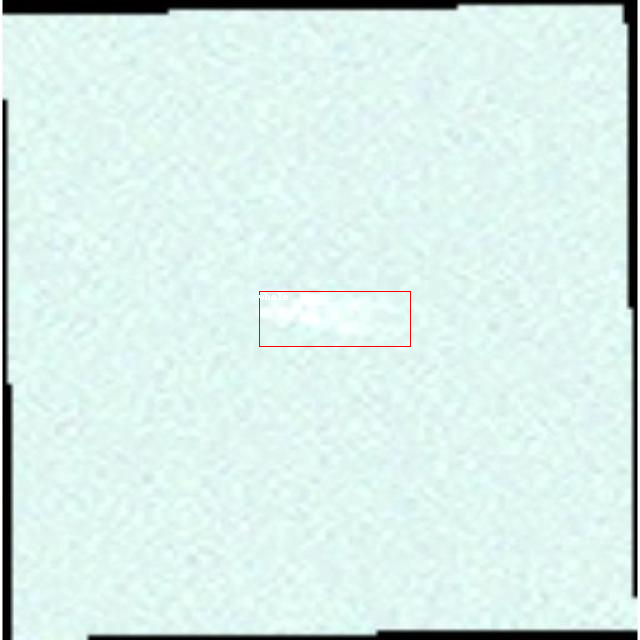

In [9]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('/kaggle/working/ships-2/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [10]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True,num_workers=4,)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=4,num_workers=4,)
batch = next(iter(train_dataloader))

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [11]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 883.2 kB/s eta 0:00:000:00:010m


In [12]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection,DetrConfig
import torch
import evaluate
import transformers

from transformers import ConvNextConfig, DetrConfig, DetrForObjectDetection,AutoBackbone,EvalPrediction

module = evaluate.load("ybelkada/cocoevaluate",coco=train_dataset.coco)
class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbone
        
         backbone = MobileNet_Transformer.from_pretrained("/kaggle/working/",local_files_only=True)   
         config = DetrConfig(backbone=backbone, use_timm_backbone=False)
         self.backbone=backbone   
         self.model = DetrForObjectDetection(config)
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       print(pixel_values.shape) 
       print(self.backbone(pixel_values)) 
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
    

       return outputs
     def on_train_epoch_end(self):
        try:
            module.compute()
        except Exception as e:
            print(e)
            pass

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
       orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
       results = processor.post_process_object_detection(outputs, threshold=0, target_sizes=orig_target_sizes)
       try:
           module.add(prediction=results, reference=labels)
       except Exception as E:
           print(E)
       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("loss",loss,prog_bar=True,sync_dist=True)
        for i,j in loss_dict.items():
            self.log(i,j,prog_bar=True,sync_dist=True)
        # logs metrics for each training_step,
        # and the average across the epoch
        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("loss",loss,prog_bar=True,sync_dist=True)
        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [13]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

AttributeError: 'NoneType' object has no attribute 'from_pretrained'

In [ ]:
import pytorch_lightning as pl
import transformers
trainer = pl.Trainer(
    max_epochs=5,
    devices=2,  # Number of GPUs to use
    accelerator='auto',  # Distributed training strategy
    strategy = 'ddp_notebook',
)
trainer.fit(model)